work-in-progress

# READ and FILTER  input dataset 
## (i.e. ERA-i prepared in model input format)

* Purpose: demonstrate how to read the DREAM model input dataset (ERA-i at the model input format, i.e. in spectral space and bianry file) and how to filter the dataset in time
* stephanie leroux 
* last update: 15/05/2020


---
# Imports

In [1]:
## standart libraries
import os,sys
import numpy as np

# xarray
import xarray as xr

# plot 
import matplotlib.pyplot as plt

# G. Serazin's xscale package (git clone https://github.com/serazing/xscale.git)
sys.path.insert(0,'/Users/leroux/WORK/DEV/TOOLS/xscale')
import xscale as xs

# if using jupyter notebook
%matplotlib inline 

---
# Read DREAM model output:

* Set parameters:

In [2]:
### local directory of input files (on my laptop)
diri = "/Users/leroux/WORK/DEV/dream-tools/wip_fortran_bash/"

# input files
filiZ = "fort2NC_Zspec.nc4"
filiD = "fort2NC_Dspec.nc4"
filiT = "fort2NC_Tspec.nc4"
filiQ = "fort2NC_Qspec.nc4"
filiSP = "fort2NC_Pspec.nc4"

In [3]:
Zspec = xr.open_dataset(diri+filiZ,decode_times=True,chunks={'spec':200})

Dspec = xr.open_dataset(diri+filiD,decode_times=True,chunks={'spec':200})

Tspec = xr.open_dataset(diri+filiT,decode_times=True,chunks={'spec':200})

Qspec = xr.open_dataset(diri+filiQ,decode_times=True,chunks={'spec':200})

SPspec = xr.open_dataset(diri+filiSP,decode_times=True,chunks={'spec':200})

In [4]:
Tspec 

<xarray.Dataset>
Dimensions:  (spec: 13860, time: 55520)
Coordinates:
  * spec     (spec) float64 9.969e+36 9.969e+36 9.969e+36 9.969e+36 ...
  * time     (time) datetime64[ns] 1979-01-01 1979-01-01T06:00:00 ...
Data variables:
    T_re     (time, spec) float64 dask.array<shape=(55520, 13860), chunksize=(55520, 200)>
    T_im     (time, spec) float64 dask.array<shape=(55520, 13860), chunksize=(55520, 200)>
Attributes:
    missing_value:  -999.0
    _FillValue:     -999.0

_Note: at this stage the datasets are open but not laoded into memory. xarray does a "lazy read" of the data until it really needs to compute and give a result._

* Test on a subset of data

In [5]:
subdat = Tspec.isel(spec=slice(0,3))['T_re']
isp=1
subdat

<xarray.DataArray 'T_re' (time: 55520, spec: 3)>
dask.array<shape=(55520, 3), dtype=float64, chunksize=(55520, 3)>
Coordinates:
  * spec     (spec) float64 9.969e+36 9.969e+36 9.969e+36
  * time     (time) datetime64[ns] 1979-01-01 1979-01-01T06:00:00 ...

---
# Center time series (remove time mean)

* compute

In [6]:
TM = subdat.mean(dim='time')
subdat_c = subdat - TM
print(TM.isel(spec=isp).values)

0.0029396631068348117


* plot one example timeseries (before centering)

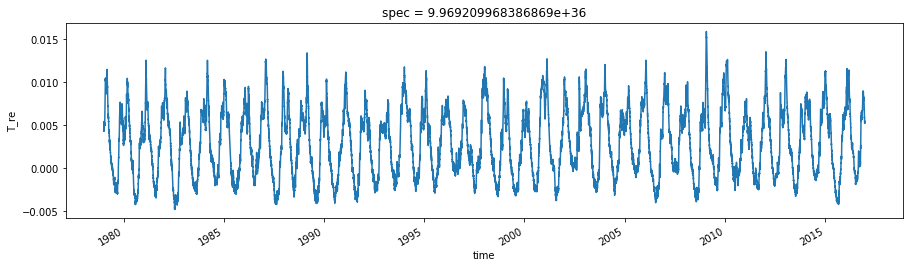

In [36]:
fig1 = plt.figure(figsize=([15,4]),facecolor='white')    
subdat.isel(spec=isp).plot()
plt.show()

* plot one example timeseries (centered)

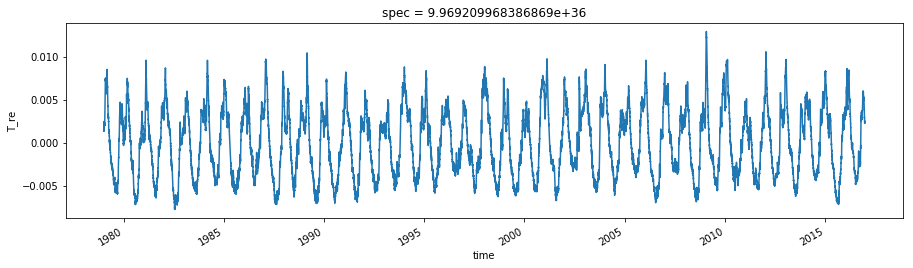

In [37]:
fig1 = plt.figure(figsize=([15,4]),facecolor='white')    
subdat_c.isel(spec=isp).plot()
plt.show()

### compute and remove linear trend

* compute

In [7]:
subdat_cdt = xs.signal.fitting.detrend(subdat_c, dim='time')

In [8]:
subdat_tr = subdat_c - subdat_cdt

* plot one example timeseries (detrended)

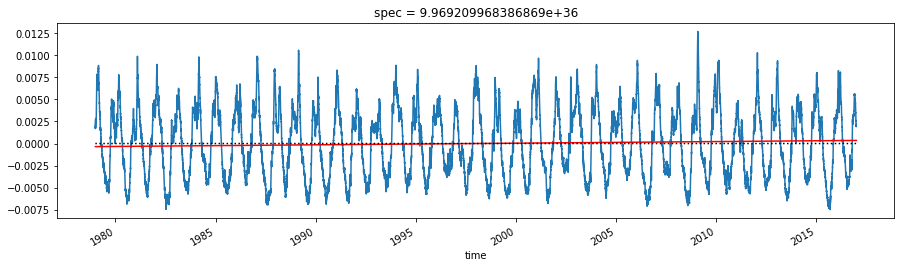

In [40]:
fig1 = plt.figure(figsize=([15,4]),facecolor='white')    
subdat_cdt.isel(spec=isp).plot()
subdat_tr.isel(spec=isp).plot(c='r')
test = subdat_tr*0.
test.isel(spec=isp).plot(c='k',linestyle=':')
plt.show()

### Compute and remove annual cycle

* compute 

In [9]:
rmAC=True
if rmAC:
    # clim over 1 year
    clim = subdat_cdt.groupby('time.dayofyear').mean(dim='time').compute()

    # rolling mean to smooth out the raw clim a little bit
    climsm = clim.rolling(dayofyear=10,min_periods=1).mean()

    # remove clim to data
    subdat_cdt_acrm = subdat_cdt.groupby('time.dayofyear')-climsm

    # annual cycle repeated over the entire pluri annual period
    anncy = subdat_cdt - subdat_cdt_acrm


* plot one example timeseries of clim smoothed

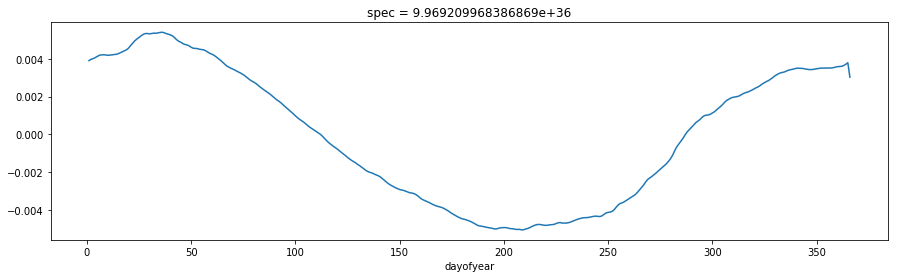

In [44]:

fig1 = plt.figure(figsize=([15,4]),facecolor='white')    
clim.isel(spec=isp).plot()
plt.show()

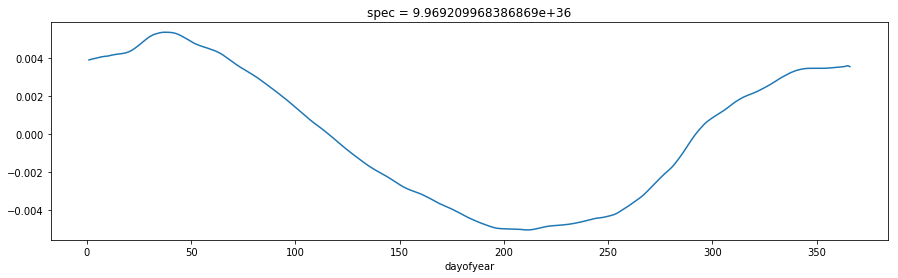

In [45]:

fig1 = plt.figure(figsize=([15,4]),facecolor='white')    
climsm.isel(spec=isp).plot()
plt.show()

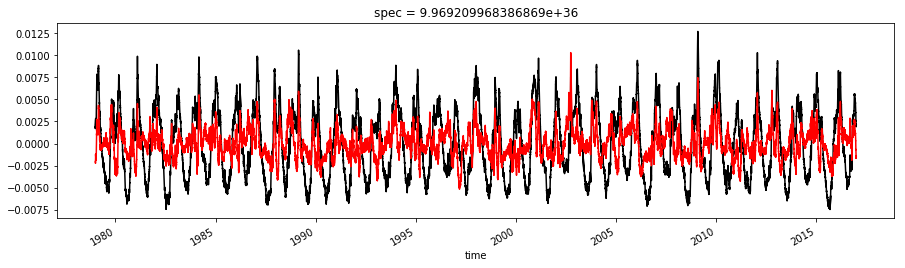

In [46]:

fig1 = plt.figure(figsize=([15,4]),facecolor='white')    
subdat_cdt.isel(spec=isp).plot(c='k')
subdat_cdt_acrm.isel(spec=isp).plot(c='r')
plt.show()

### Filter in time

In [20]:
truc = subdat_cdt_acrm.isel(spec=isp)

In [21]:
truc

<xarray.DataArray (time: 55520)>
dask.array<shape=(55520,), dtype=float64, chunksize=(55520,)>
Coordinates:
    spec       float64 9.969e+36
  * time       (time) datetime64[ns] 1979-01-01 1979-01-01T06:00:00 ...
    dayofyear  (time) int64 1 1 1 1 2 2 2 2 3 3 3 3 4 4 4 4 5 5 5 5 6 6 6 6 ...

In [14]:
def filt(w,cutoff=45,dx=0.25):
    win_box= w.window
    win_box.set(window='hanning',cutoff=cutoff,dim='time',dx=dx)
    bw = win_box.boundary_weights(drop_dims=[])
    w_LS = win_box.convolve(weights=bw)
    w_SS=w-w_LS
    w_SS=w_SS
    return w_SS,w_LS

In [22]:
subdat_cdt_acrm_SS45,subdat_cdt_acrm_LS45 = filt(truc,cutoff=20,dx=0.25)

In [23]:
subdat_cdt_acrm_LS45

<xarray.DataArray (time: 55520)>
dask.array<shape=(55520,), dtype=float64, chunksize=(55520,)>
Coordinates:
    spec       float64 9.969e+36
  * time       (time) datetime64[ns] 1979-01-01 1979-01-01T06:00:00 ...
    dayofyear  (time) int64 dask.array<shape=(55520,), chunksize=(55520,)>

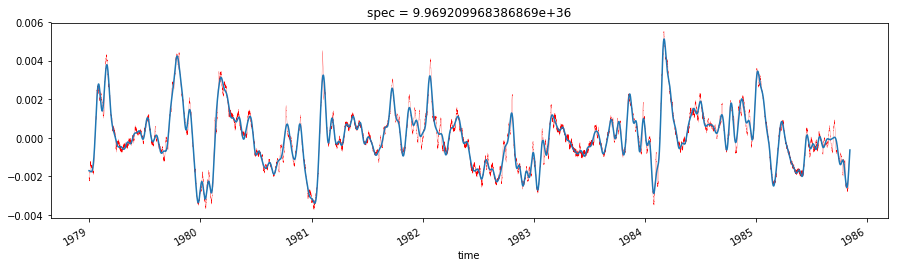

In [24]:
fig1 = plt.figure(figsize=([15,4]),facecolor='white')        
truc.isel(time=slice(0,10000)).plot(c='r',linewidth=0.2)
subdat_cdt_acrm_LS45.isel(time=slice(0,10000)).plot()
plt.show()

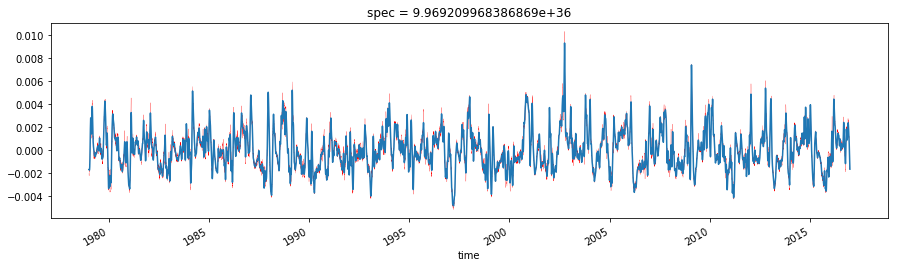

In [25]:
fig1 = plt.figure(figsize=([15,4]),facecolor='white')        
truc.plot(c='r',linewidth=0.2)
subdat_cdt_acrm_LS45.plot()
plt.show()